In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = yf.download("BCH-USD", start="2021-03-31", end="2022-03-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
data['Adj Close'].head()

Date
2021-03-30    527.698242
2021-03-31    543.237854
2021-04-01    561.658264
2021-04-02    585.707458
2021-04-03    536.678833
Name: Adj Close, dtype: float64

In [4]:
data['Adj Close'].tail()

Date
2022-03-26    361.893463
2022-03-27    376.537445
2022-03-28    368.139282
2022-03-29    373.529968
2022-03-30    379.637817
Name: Adj Close, dtype: float64

In [5]:
S = data['Adj Close'][-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 379.64 .


In [6]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
vol_h = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 119.73 %


array([<AxesSubplot:xlabel='Date'>], dtype=object)

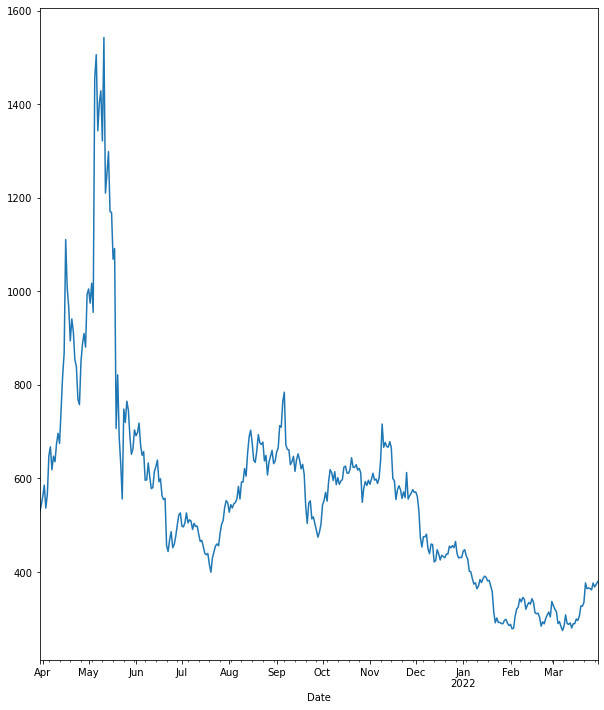

In [7]:
data['Adj Close'].plot(figsize=(10, 12), subplots=True)

# BINOMIAL TREE

In [8]:
import numpy as np
import os

In [9]:
S0 = 379.64              # spot stock price
K = 350.00               # strike
T = 1/12                 # maturity 
r = 0.0172               # risk free rate 
sig = 1.19               # diffusion coefficient or volatility
N = 3                    # number of periods or number of time steps  
payoff = "put"           # payoff 

In [10]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [11]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [12]:
S

array([[379.64      , 462.92116453, 564.47161672, 688.29906794],
       [  0.        , 311.34141328, 379.64      , 462.92116453],
       [  0.        ,   0.        , 255.3299853 , 311.34141328],
       [  0.        ,   0.        ,   0.        , 209.39521251]])

In [13]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p


0.45177547166154697

In [14]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  38.65858672],
       [  0.        ,   0.        ,   0.        , 140.60478749]])

In [15]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 38.85889162,  11.60774625,   0.        ,   0.        ],
       [  0.        ,  61.34962081,  21.18346207,   0.        ],
       [  0.        ,   0.        ,  94.50283242,  38.65858672],
       [  0.        ,   0.        ,   0.        , 140.60478749]])

In [16]:
print('European ' + payoff, str( V[0,0]))

European put 38.85889161752236


# Monte Carlo

In [17]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [18]:
T = 1/12
r = 0.0172
sigma = 1.19
S0 = 379.64
K = 350

In [19]:
S = mcs_simulation_np(10000)

In [20]:
S = np.transpose(S)
S

array([[379.64      , 380.02295974, 379.31671994, ..., 311.03797807,
        311.78325071, 313.7609468 ],
       [379.64      , 382.90848633, 383.07462593, ..., 222.96594313,
        223.87563691, 223.03484307],
       [379.64      , 379.14299254, 378.27246346, ..., 490.22951281,
        489.71984038, 489.66406757],
       ...,
       [379.64      , 382.23103356, 382.8386242 , ..., 295.80561291,
        295.52992419, 295.26404045],
       [379.64      , 379.94217696, 379.8649016 , ..., 681.71338703,
        685.2924806 , 688.58896866],
       [379.64      , 378.58387705, 379.15394244, ..., 324.88763013,
        321.82454344, 323.05415429]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values of BCH-USD')

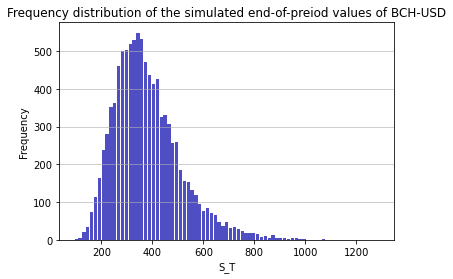

In [21]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values of BCH-USD')

In [22]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 34.954507939392826


In [23]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 65.24159294091898


# Black and Scholes

In [24]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [25]:
S = 379.64
K = 350.0
T = 1/12
r = 0.0172

In [26]:
put = euro_option_bs(S, K, T, r, vol_h, 'put')
print('The BS put price is', round(put, 2))

The BS put price is 36.36


In [27]:
call = euro_option_bs(S, K, T, r, vol_h, 'call')
print('The BS call price is', round(call, 2))

The BS call price is 66.5


In [78]:
S = np.linspace(250,650,101)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 350.0, 1/12, 0.0172, 1.19, 'call')

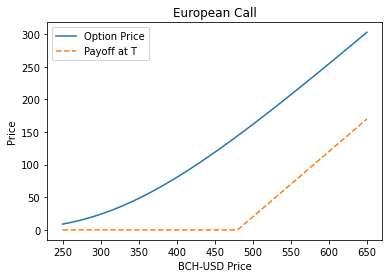

In [79]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-480,0), '--')
plt.xlabel('BCH-USD Price')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price','Payoff at T'])

In [76]:
S = np.linspace(250,650,101)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = euro_option_bs(S[i], 350, 1/12, 0.0172, 1.19, 'put')

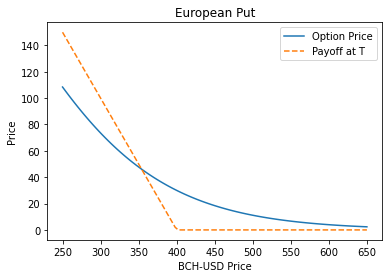

In [77]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.plot(S, np.maximum(400-S,0), '--')
plt.xlabel('BCH-USD Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

# GREEKS

# DELTA

In [84]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [33]:
delta(379.64, 350.0, 1/12, 0.0172, 0, 1.19, 'call')

0.6600395068598615

In [34]:
delta(379.64, 350.0, 1/12, 0.0172, 0, 1.19, 'put')


-0.3399604931401386

In [35]:
S = np.linspace(250,650,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 350.0, 1/12, 0.0172, 0, 1.19, 'call')
    Delta_Put [i] = delta(S[i], 350.0, 1/12, 0.0172, 0, 1.19, 'put')

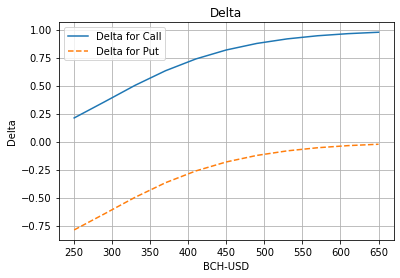

In [37]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('BCH-USD')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [38]:
S = np.linspace(250, 650, 51)
T = np.linspace(0.01, 0.31, 31)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 350, T[i], 0.0172, 0, 1.19, 'call')

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_60300/873040967.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


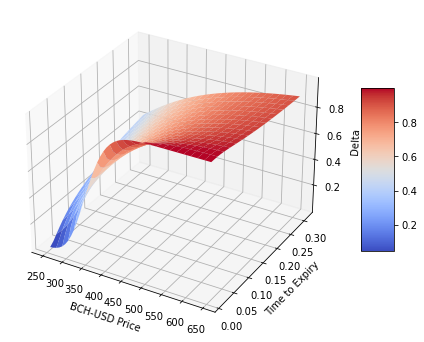

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('BCH-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# GAMMA

In [40]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [41]:
gamma(379.64, 350, 1/12, 0.0172, 0, 1.19, 'call')

0.0028094421277173273

In [42]:
gamma(379.64, 350, 1/12, 0.0172, 0, 1.19, 'put')

0.0028094421277173273

In [80]:
S = np.linspace(250,650,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 350, 1/12, 0.0172, 0, 1.19, 'call')

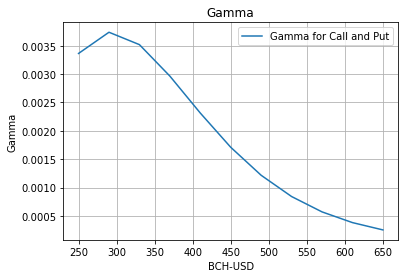

In [81]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('BCH-USD')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

# SURFACE OF GAMMA

In [45]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [46]:
S = np.linspace(250, 650, 51)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 350, T[i], 0.0172, 0, 1.19, 'call')

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_60300/754434301.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


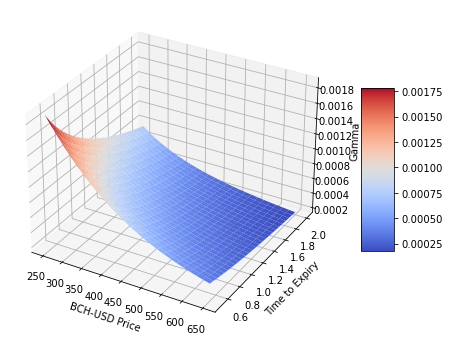

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('BCH-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# SPEED

In [48]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [49]:
speed(379.64, 350.0, 1/12, 0.0172, 0, 1.19, 'call')

-4.701940885549449e-06

In [50]:
speed(379.64, 350, 1/12, 0.0172, 0.03, 1.19, 'put')

-4.658901156619194e-06

In [82]:
S = np.linspace(250,650,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 350, 1/12, 0.0172, 0, 1.19, 'call')

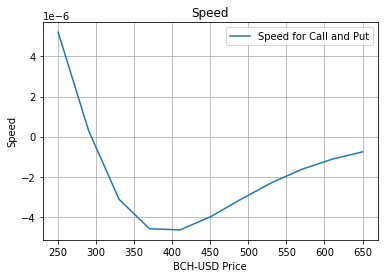

In [83]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('BCH-USD Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

In [ ]:
# def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [54]:
S = np.linspace(250, 650, 101)
T = np.linspace(0.5, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 350.0, T[i], 0.0172, 0, 1.19, 'call')

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_60300/2061354415.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


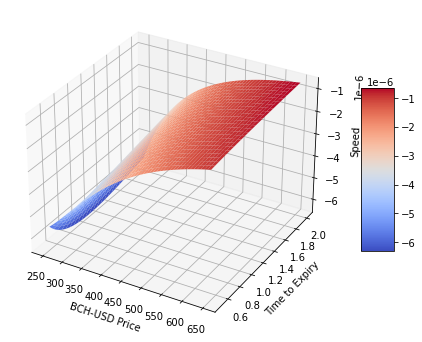

In [55]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('BCH-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

# THETA

In [56]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [57]:
theta(379.64, 350.0, 1/12, 0.0172, 0, 1.19, 'call')

289.87131428037975

In [58]:
theta(379.64, 350.0, 1/12, 0.0172, 0, 1.19, 'put')

289.5403986238686

In [59]:
T = np.linspace(1,31,31)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(379.64, 350.0, T[i], 0.0172, 0, 1.19, 'call')
    Theta_Put [i] = theta(379.64, 350.0, T[i], 0.0172, 0, 1.19, 'put')

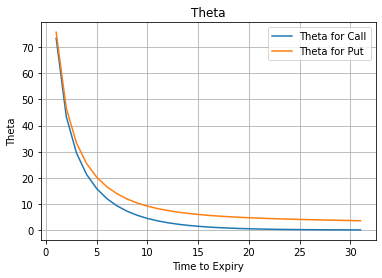

In [60]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

# SURFACE OF THETA 

In [63]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [65]:
S = np.linspace(250, 650, 101)
T = np.linspace(1, 31, 31)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 350.0, T[i], 0.0172, 0, 1.17, 'call')

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_60300/3255719091.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


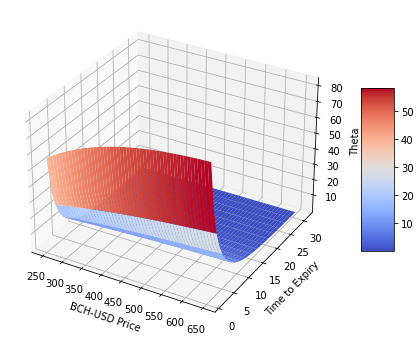

In [66]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('BCH-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# RHO

In [67]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [68]:
rho(379.64, 350, 1/12, 0.0172, 0, 1.19, 'call')

15.364082293529096

In [69]:
rho(379.64, 350.0, 1/12, 0.0172, 0, 1.19, 'put')

-13.760808763920759

In [85]:
r = np.linspace(0,0.1,50)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(379.64, 350.0, 1/12, r[i], 0, 1.19, 'call')
    Rho_Put [i] = rho(379.64, 350.0, 1/12, r[i], 0, 1.19, 'put')

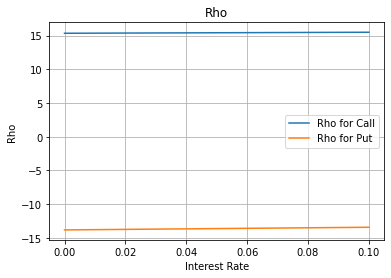

In [86]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

# SURFACE OF RHO

In [72]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [73]:
S = np.linspace(250, 650, 101)
T = np.linspace(0.5, 2, 101)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 350.0, T[i], 0.0172, 0, 1.19, 'call')

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_60300/557196965.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


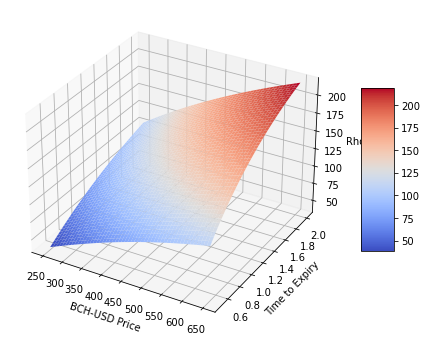

In [74]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('BCH-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);